In [1]:
# Downlaod and place data on Google Drive
# Mount with Drive and Get Dataset
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/cv/intel-image-classification.zip" /content/intel-image-classification.zip
!unzip -q intel-image-classification.zip # -q for quiet


Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/cv/Test_data.zip" /content/Test_data.zip
!unzip -q Test_data.zip # -q for quiet 

In [1]:
!ls

drive				sample_data  seg_test	Test_data.zip
intel-image-classification.zip	seg_pred     seg_train


In [2]:
# Load data
path_train = "/content/seg_train/seg_train"
path_test = "/content/seg_test/seg_test"
path_pred = "/content/seg_pred/seg_pred"

In [3]:
from keras.preprocessing.image import ImageDataGenerator
batch_size=32
datagen_args = dict(rotation_range=20,width_shift_range=0.2,
    height_shift_range=0.2,rescale=1./255)
datagen_train = ImageDataGenerator(**datagen_args)
datagenerator_train = datagen_train.flow_from_directory(path_train,class_mode='categorical',
                                            target_size=(150,150),interpolation="lanczos",shuffle=True)


Found 14034 images belonging to 6 classes.


In [4]:
datagen_test = ImageDataGenerator(**datagen_args)
datagenerator_test = datagen_test.flow_from_directory(path_test,class_mode='categorical',
                                            target_size=(150,150),interpolation="lanczos",shuffle=True)

Found 3000 images belonging to 6 classes.


In [5]:
datagen_pred = ImageDataGenerator(**datagen_args)
datagenerator_pred = datagen_pred.flow_from_directory(path_pred,class_mode='categorical',
                                            target_size=(150,150),interpolation="lanczos",shuffle=True)

Found 7301 images belonging to 6 classes.


In [7]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [8]:
# load VGG16 model without classification layers
model = VGG16(include_top=False, input_shape=(150, 150, 3))

In [9]:
model.layers[16].trainable = False

In [10]:
model.layers[16].trainable

False

In [11]:
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [12]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

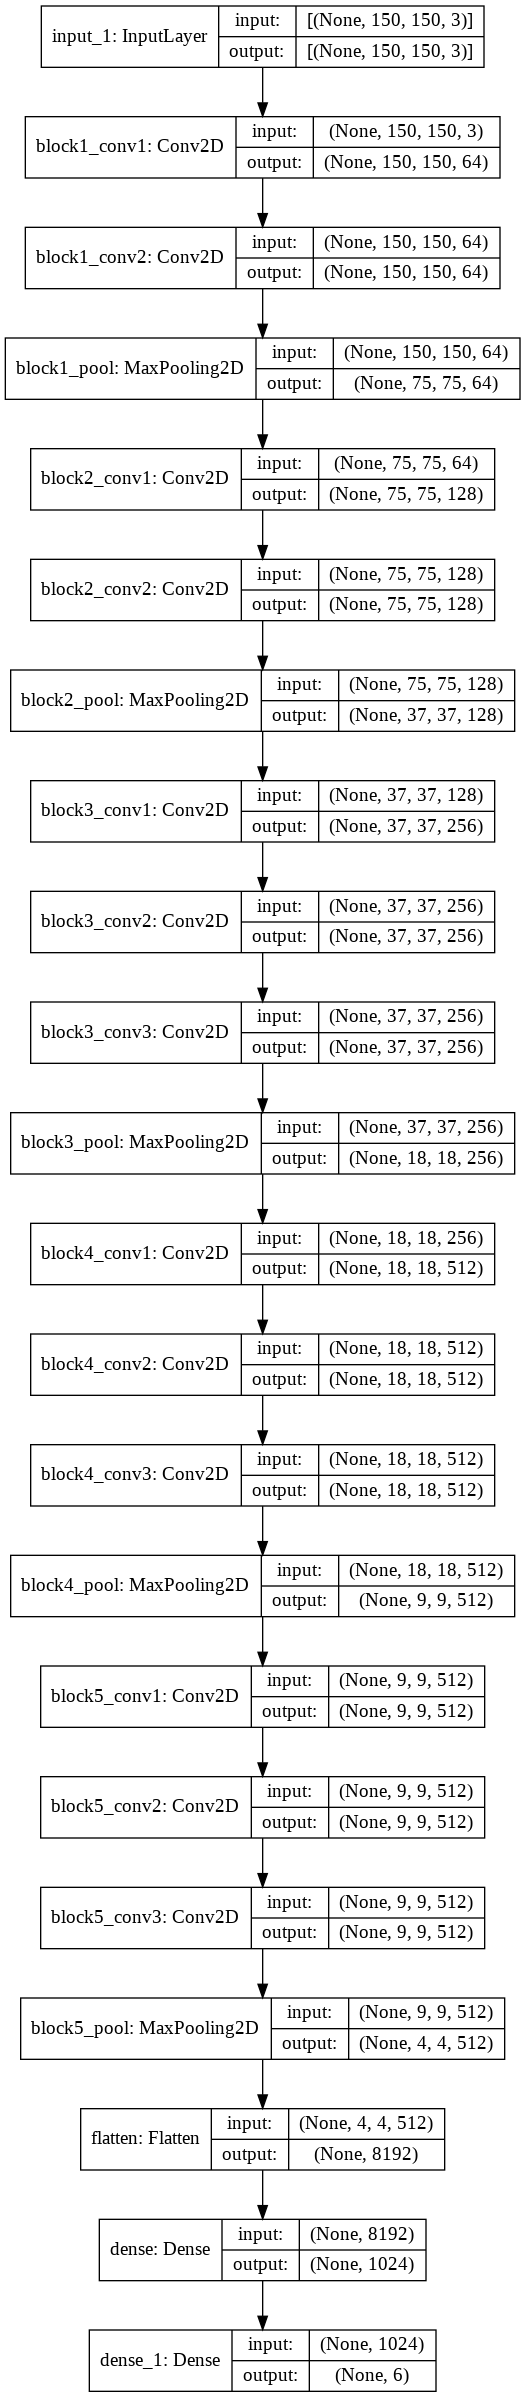

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [15]:
H = model.fit(datagenerator_train, batch_size=128,
              epochs=10, 
              validation_data=(datagenerator_test))

Epoch 1/10
439/439 [==============================] - 137s 291ms/step - loss: 0.7543 - accuracy: 0.7063 - val_loss: 0.3579 - val_accuracy: 0.8690
Epoch 2/10
439/439 [==============================] - 126s 288ms/step - loss: 0.3124 - accuracy: 0.8927 - val_loss: 0.2931 - val_accuracy: 0.8927
Epoch 3/10
439/439 [==============================] - 126s 287ms/step - loss: 0.2659 - accuracy: 0.9057 - val_loss: 0.2595 - val_accuracy: 0.9040
Epoch 4/10
439/439 [==============================] - 126s 288ms/step - loss: 0.2238 - accuracy: 0.9198 - val_loss: 0.2769 - val_accuracy: 0.8997
Epoch 5/10
439/439 [==============================] - 126s 288ms/step - loss: 0.2038 - accuracy: 0.9277 - val_loss: 0.2427 - val_accuracy: 0.9090
Epoch 6/10
439/439 [==============================] - 126s 287ms/step - loss: 0.1877 - accuracy: 0.9325 - val_loss: 0.2691 - val_accuracy: 0.9063
Epoch 7/10
439/439 [==============================] - 126s 287ms/step - loss: 0.1607 - accuracy: 0.9431 - val_loss: 0.2507 -

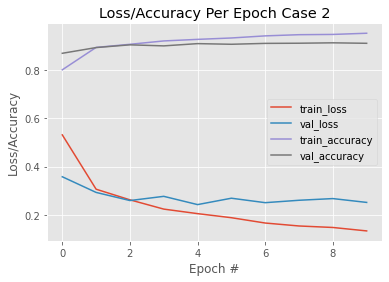

In [16]:
'''LEARNING CURVE'''
import numpy as np
import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Loss/Accuracy Per Epoch Case 2')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [17]:
# save the model's trained weights
model.save_weights('vgg_transfer_trained_wts_case_2.h5')

In [18]:
!cp "/content/vgg_transfer_trained_wts_case_2.h5" "/content/drive/MyDrive/cv/vgg_transfer_trained_wts_case_2.h5"

In [19]:
score = model.evaluate(datagenerator_test, batch_size=64)
print('Test Loss Case 2 = ', score[0])
print('Test Accuracy Case 2 = ', score[1])

94/94 [==============================] - 18s 188ms/step - loss: 0.2565 - accuracy: 0.9083
Test Loss Case 2 =  0.2565038204193115
Test Accuracy Case 2 =  0.9083333611488342


In [20]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict(datagenerator_pred)
y_true = np.argmax(y_pred, axis=-1)


In [21]:

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion_mtx

array([[1024,    0,    0,    0,    0,    0],
       [   0, 1201,    0,    0,    0,    0],
       [   0,    0, 1150,    0,    0,    0],
       [   0,    0,    0, 1438,    0,    0],
       [   0,    0,    0,    0, 1180,    0],
       [   0,    0,    0,    0,    0, 1308]])